# Analyze

In [156]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import common_functions as cf

import importlib

importlib.reload(cf)

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 1
ARRAY_H = 1
ARRAY_SIZE = ARRAY_W * ARRAY_H
NAME_PREFIX = lambda i: f"H1_5-s0-20231218-Y"
#NAMES = [f"H1_5_s{i}" for i in range(ARRAY_SIZE)]


In [157]:
NAMES = [f"{NAME_PREFIX(i)}" for i in range(ARRAY_SIZE)]
data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

all_data = []

# Loading data (but not in 1 pd.DataFrame)
for name in NAMES:
    TFdata = cf.read_csv_file(f"../data/raw/TF/{name}.csv") 
    sensordata = cf.read_csv_file(f'../data/raw/sensor/{name}.csv')
    
    # Time sync
    data = cf.time_sync_data(sensordata, TFdata, SENSOR_LAG / 1000)

    # Remove mean of first 100 samples
    data = cf.offset_data(data, data_columns, 100)

    all_data.append(data)

print("Data loaded. Taxel 0 sensor test")
all_data[0].info()

Data loaded. Taxel 0 sensor test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857 entries, 0 to 3856
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    3857 non-null   int64  
 1   t_wall   3857 non-null   float64
 2   X0       3856 non-null   float64
 3   Y0       3856 non-null   float64
 4   Z0       3856 non-null   float64
 5   X1       3856 non-null   float64
 6   Y1       3856 non-null   float64
 7   Z1       3856 non-null   float64
 8   X2       3856 non-null   float64
 9   Y2       3856 non-null   float64
 10  Z2       3856 non-null   float64
 11  X3       3856 non-null   float64
 12  Y3       3856 non-null   float64
 13  Z3       3856 non-null   float64
 14  t_robot  3857 non-null   float64
 15  F_x      3857 non-null   float64
 16  F_y      3857 non-null   float64
 17  F_z      3857 non-null   float64
 18  T_x      3857 non-null   float64
 19  T_y      3857 non-null   float64
 20  T_z      3857 non-n

In [158]:
all_data[0].head()

,index,t_wall,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,X3,Y3,Z3,t_robot,F_x,F_y,F_z,T_x,T_y,T_z
0,1294,1.702924e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18573.470,-0.042177,-0.061848,0.099512,-0.000252,0.001008,-0.000818
1,0,1.702924e+09,-0.001392,0.004358,-0.001965,201.30,207.90,491.2600,167.40,245.70,...,149.10,214.80,443.3440,18573.477,-0.025610,-0.051698,0.138797,-0.000037,0.000588,-0.000492
2,1,1.702924e+09,0.005208,0.005858,-0.003417,202.20,211.50,491.2600,170.70,252.90,...,148.80,214.80,440.4400,18573.484,-0.009043,-0.041548,0.178082,0.000179,0.000167,-0.000166
3,2,1.702924e+09,-0.005292,-0.001342,-0.007773,202.50,208.80,490.2920,164.40,252.00,...,155.10,215.40,448.1840,18573.491,0.007523,-0.031398,0.217367,0.000394,-0.000253,0.000160
4,1295,1.702924e+09,-0.003192,-0.000622,-0.006709,202.56,209.46,491.9376,165.72,251.04,...,155.64,214.92,445.5704,18573.498,0.024090,-0.021248,0.256652,0.000609,-0.000673,0.000486


# Add features

In [159]:
for j in range(ARRAY_SIZE):
    data = all_data[j]
    
    data['F_xy'] = np.sqrt(data['F_x']**2 + data['F_y']**2)
    data['F_m'] = np.sqrt(data['F_x']**2 + data['F_y']**2 + data['F_z']**2)
    
    for i in range(ARRAY_SIZE):
        data[f'XY{i}'] = np.sqrt(data[f'X{i}']**2 + data[f'Y{i}']**2)
        data[f'M{i}'] = np.sqrt(data[f'X{i}']**2 + data[f'Y{i}']**2 + data[f'Z{i}']**2)

# Scatterplots

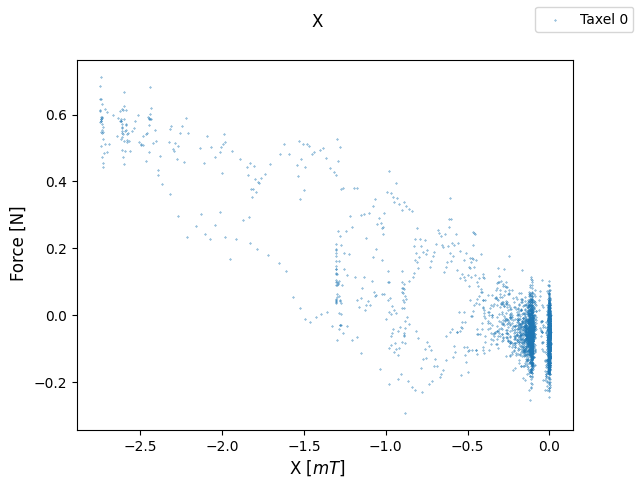

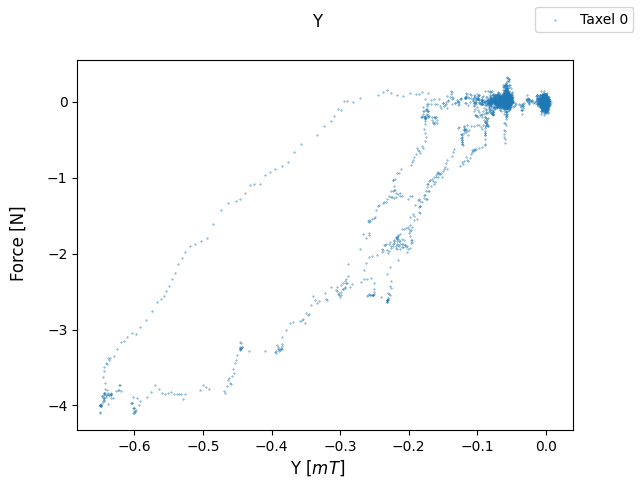

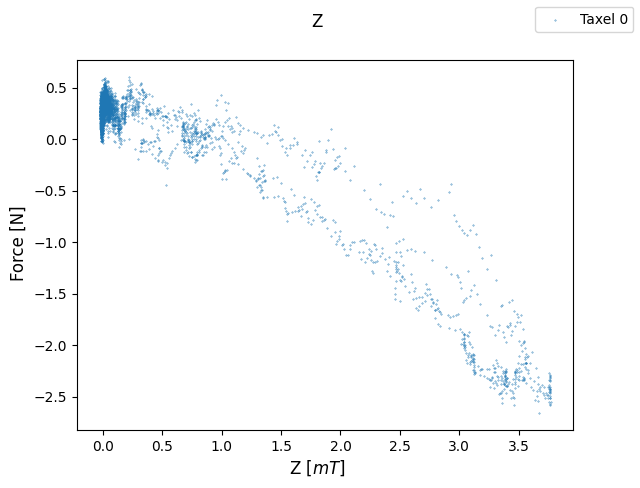

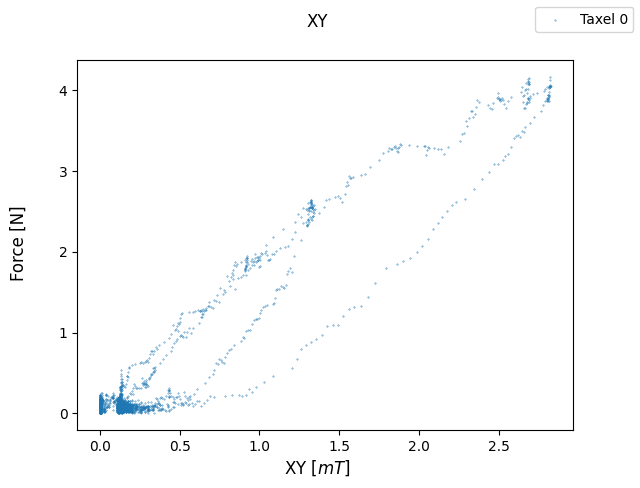

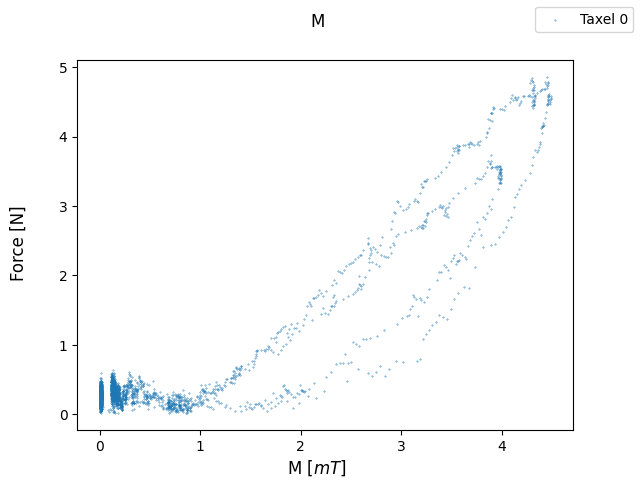

In [161]:
for letter in ['X', 'Y', 'Z', 'XY', 'M']:

  fig = plt.figure()
  gs = fig.add_gridspec(ARRAY_H, ARRAY_W)
  axs = gs.subplots()
  
  for i in range(ARRAY_SIZE):
    data = all_data[i]
    for w in range(ARRAY_W):
      for h in range(ARRAY_H):
        if ARRAY_SIZE == 1:
          ax = axs
        elif ARRAY_W == 1 or ARRAY_H == 1:
          ax = axs[i]
        else:    
          ax = axs[h, w]
        
        ax.scatter(data[f'{letter}{w*ARRAY_W+h}'], data[f'F_{letter.lower()}'], s=0.1, alpha=1, label=f'Taxel {i}')
      
  fig.supylabel('Force [N]')
  fig.supxlabel(fr'{letter} [$mT$]')

  lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes[:1]]
  lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
  fig.legend(lines, labels)
  
  plt.suptitle(f'{letter}')
  plt.show()